<h1 style="text-align:center;">Лабораторная работа 1. Линейная регрессия и факторный анализ</h1>

---

<h2><b>Цель работы</b></h2>

Изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.

---

<h2><b>Постановка задачи</b></h2>

1. Провести обучение модели линейной регрессии на датасете с Kaggle.  
2. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ).  
3. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной.  
4. Провести предобработку данных: удалить пропущенные значения, закодировать категориальные переменные (опционально).  
5. Построить **матрицу корреляций** и сделать выводы о наличии мультиколлинеарности (расчёт VIF-коэффициента).  
6. Построить **регрессионные модели (линейная и гребневая)**.  
   - Разделить на тренировочную и тестовую выборки (80/20 или 70/30).  
   - Использовать кросс-валидацию.  
   - Оценить качество модели с помощью метрик: **RMSE**, **R²**, **MAPE**.  
7. Устранить мультиколлинеарность и снизить размерность признаков с помощью **метода главных компонент (PCA)**. Перед проведением PCA — выполнить стандартизацию данных.  
8. Повторить шаг 6, но использовать **главные компоненты** вместо исходных признаков.  
   - Сравнить метрики качества (**RMSE**, **R²**, **MAPE**) для обеих моделей.  

In [63]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prince7489/e-commerce-sales")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\vaind\.cache\kagglehub\datasets\prince7489\e-commerce-sales\versions\1


Импорт датасета
<h3>Описание датасета</h3>

Данный датасет содержит синтетическую, но реалистичную выборку данных о продажах интернет-магазина за период с 2024 по 2025 год.  
Он включает информацию о заказах, клиентах, товарах, регионах, ценах, скидках, продажах, прибыли и способах оплаты.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Импорт библиотек

In [76]:
dataset_path = r"C:\Users\vaind\OneDrive\Desktop\ml\datasets\Ecommerce_Sales_Data_2024_2025.csv"
df = pd.read_csv(dataset_path)
df.drop(columns=['Order ID', 'Order Date'], inplace=True)
df.head()

,Customer Name,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


In [83]:
import pandas as pd
import numpy as np

# Отбор только числовых столбцов
numeric_df = df.select_dtypes(include=[np.number])

print("ИНФОРМАЦИЯ О ДАННЫХ")
df.info()

print("\nОПИСАТЕЛЬНАЯ СТАТИСТИКА")
display(df.describe().round(2))

print("\nСРЕДНИЕ И МЕДИАНЫ")
summary = pd.DataFrame({
    'Среднее': numeric_df.mean().round(2),
    'Медиана': numeric_df.median().round(2),
})
summary['Разница'] = (summary['Среднее'] - summary['Медиана']).abs().round(2)
summary['Отношение (ср/мед)'] = (summary['Среднее'] / summary['Медиана']).round(2)
display(summary)

print("\nАСИММЕТРИЯ И ЭКСЦЕСС")
asym = pd.DataFrame({
    'Асимметрия': numeric_df.skew().round(3),
    'Эксцесс': numeric_df.kurtosis().round(3)
})
display(asym)

ИНФОРМАЦИЯ О ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Customer Name  5000 non-null   object 
 1   Region         5000 non-null   object 
 2   City           5000 non-null   object 
 3   Category       5000 non-null   object 
 4   Sub-Category   5000 non-null   object 
 5   Product Name   5000 non-null   object 
 6   Quantity       5000 non-null   int64  
 7   Unit Price     5000 non-null   int64  
 8   Discount       5000 non-null   int64  
 9   Sales          5000 non-null   float64
 10  Profit         5000 non-null   float64
 11  Payment Mode   5000 non-null   object 
dtypes: float64(2), int64(3), object(7)
memory usage: 468.9+ KB

ОПИСАТЕЛЬНАЯ СТАТИСТИКА


,Quantity,Unit Price,Discount,Sales,Profit
count,5000.00,5000.00,5000.00,5000.00,5000.00
mean,2.99,39760.90,10.05,106733.20,15941.75
std,1.41,22831.78,7.08,85108.21,14897.68
min,1.00,222.00,0.00,264.10,19.12
25%,2.00,20312.25,5.00,39766.54,4892.30
50%,3.00,39459.50,10.00,83080.32,11108.53
75%,4.00,59721.75,15.00,156968.59,22467.99
max,5.00,79998.00,20.00,398485.00,89688.44



СРЕДНИЕ И МЕДИАНЫ


,Среднее,Медиана,Разница,Отношение (ср/мед)
Quantity,2.99,3.00,0.01,1.00
Unit Price,39760.90,39459.50,301.40,1.01
Discount,10.05,10.00,0.05,1.01
Sales,106733.20,83080.32,23652.88,1.28
Profit,15941.75,11108.53,4833.22,1.44



АСИММЕТРИЯ И ЭКСЦЕСС


,Асимметрия,Эксцесс
Quantity,-0.006,-1.298
Unit Price,0.024,-1.185
Discount,-0.008,-1.299
Sales,0.953,0.187
Profit,1.505,2.254


<h3>Первичный анализ</h3>

В датасете 5000 записей и 12 признаков, из которых 5 числовых и 7 категориальных. Пропусков нет, структура данных чистая. Средние и медианные значения по количественным признакам близки друг к другу, что указывает на отсутствие сильных выбросов в большинстве переменных, кроме Sales и Profit, где средние заметно выше медиан, что говорит о правосторонней асимметрии распределения и наличии крупных продаж или прибылей. Это подтверждается положительными значениями асимметрии (0.95 и 1.50 соответственно) и высоким эксцессом у прибыли (2.25), что указывает на «тяжёлые хвосты» распределения.

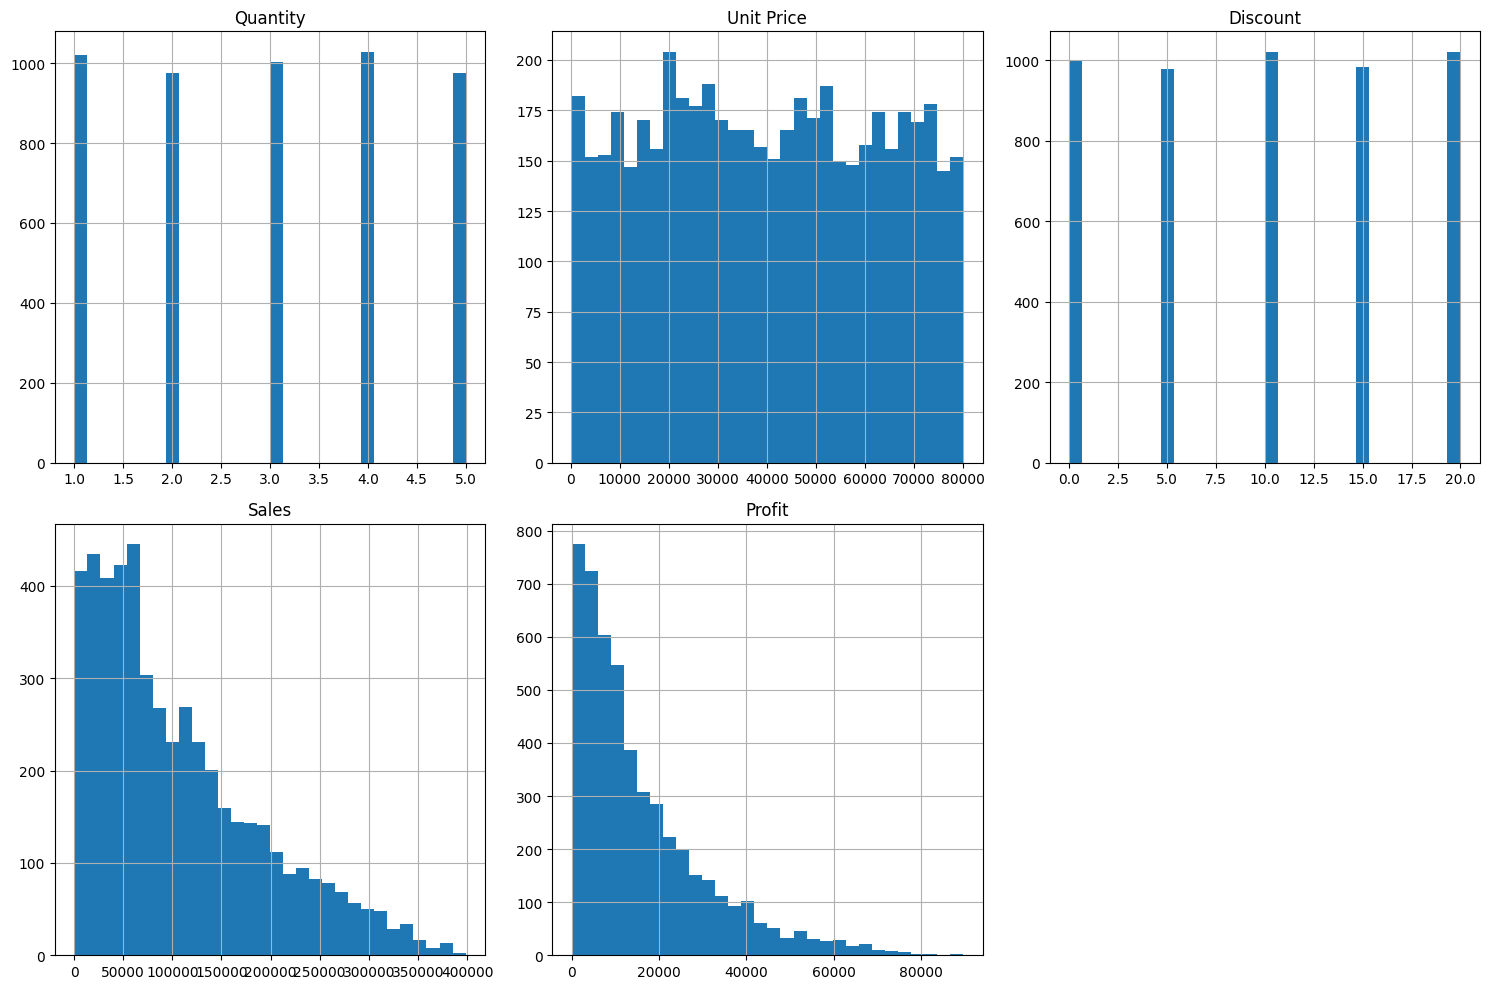

In [84]:
numeric_df.hist(bins=30, figsize=(15, 10), layout=(len(numeric_df.columns)//3 + 1, 3))
plt.tight_layout()
plt.show()

<h3>Распределение признаков</h3>

Распределение Quantity и Discount дискретное и равномерное — значения принимают лишь несколько фиксированных уровней (1–5 и 0–20), что указывает на категориальный характер этих признаков, выраженных числами. Признак Unit Price имеет почти равномерное распределение по диапазону цен. Распределения Sales и Profit сильно правосторонние (асимметричные): большинство значений сосредоточено вблизи нижней границы, а количество больших продаж и прибылей постепенно снижается.

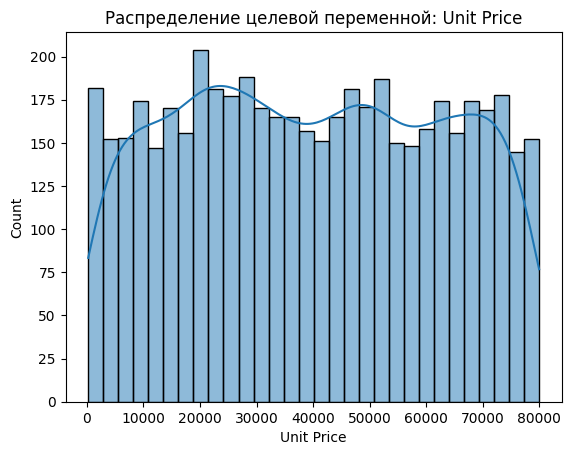

In [85]:
target = "Unit Price"

sns.histplot(df[target], kde=True, bins=30)
plt.title(f"Распределение целевой переменной: {target}")
plt.show()

<b>Целевая переменная: </b> Unit Price - количественная метрика стоимости одной единицы продукции в денежном выражении 

In [86]:
numeric_df.isnull().mean() * 100

Quantity      0.0
Unit Price    0.0
Discount      0.0
Sales         0.0
Profit        0.0
dtype: float64

Пропущенные значения

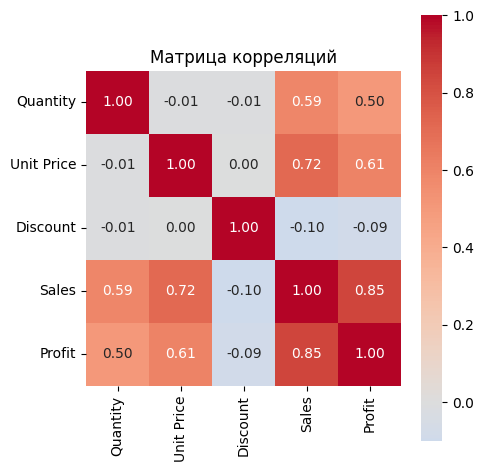

In [87]:
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Матрица корреляций')
plt.tight_layout()
plt.show()

<h3>Описание корреляций</h3>

Наиболее сильные положительные связи наблюдаются между показателями Sales и Profit (0.85), а также между Sales и Unit Price (0.72). Это указывает на то, что выручка тесно связана с получаемой прибылью и ценой товара. Умеренная корреляция также существует между Profit и Unit Price (0.61) и между Sales и Quantity (0.59). При этом переменная Discount практически не коррелирует с другими факторами, демонстрируя очень слабые связи, а наиболее сильная из них - слабая отрицательная с Sales (-0.10).

In [70]:

numeric_df = df.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i)
                   for i in range(numeric_df.shape[1])]

print(vif_data)

      Feature        VIF
0    Quantity   6.189467
1  Unit Price   7.623430
2    Discount   3.201666
3       Sales  17.128113
4      Profit   7.674868


Значения VIF меньше 10(для всех полей кроме Sale), мультиколинеарность незначительная

Значения VIF больше 10 для Sale, мультиколинеарность большая
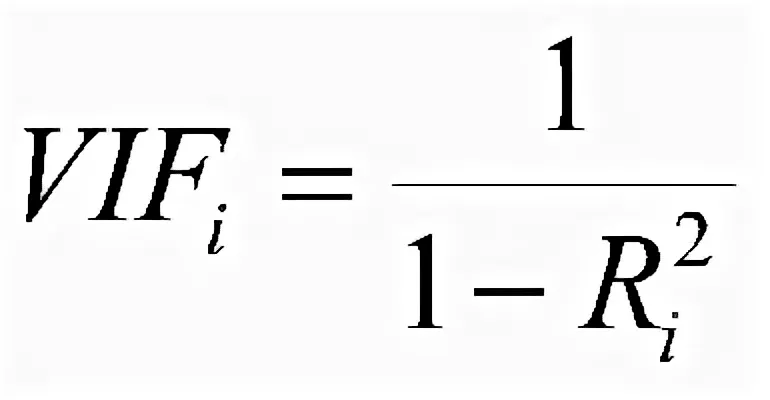

In [69]:
X = numeric_df.drop(columns=[target])
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

print("Линейная регрессия:")
print("R^2:", r2_score(y_test, y_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lin)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_lin))

Линейная регрессия:
R^2: 0.8146103879848039
RMSE: 9970.26276925876
MAPE: 0.996579708492009


Линейная регрессия показала хороший результат: значение коэффициента детерминации 
R^2=0.81говорит о том, что модель объясняет около 81% вариации целевой переменной, то есть предсказания достаточно точны. При этом среднеквадратичная ошибка (RMSE) составляет примерно 9970, что отражает среднее отклонение предсказаний от фактических значений в тех же единицах, что и целевая переменная. Однако значение MAPE около 1 (99.6%) указывает на высокую среднюю относительную ошибку, что может означать наличие выбросов или сильной неоднородности данных, влияющих на качество предсказаний.
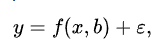

In [68]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

y_pred_ridge = ridge_reg.predict(X_test)

print("\nГребневая регрессия (Ridge):")
print("R^2:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_ridge))


Гребневая регрессия (Ridge):
R^2: 0.8146142385376304
RMSE: 9970.159227257624
MAPE: 0.9964599075084282


Гребневая регрессия (Ridge) показала почти идентичные результаты по сравнению с обычной линейной регрессией: коэффициент детерминации 
R^2=0.81 свидетельствует о том, что модель объясняет около 81% дисперсии целевой переменной. Значение RMSE (≈9970) подтверждает, что среднее отклонение предсказаний от реальных данных остаётся на том же уровне, а MAPE (~99.6%) указывает на значительные относительные ошибки. Это говорит о том, что регуляризация почти не повлияла на качество модели, что может означать отсутствие мультиколлинеарности или переобучения в исходных данных.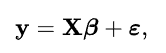

In [67]:
X = numeric_df.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


  Feature  VIF
0     PC1  1.0
1     PC2  1.0
2     PC3  1.0
3     PC4  1.0


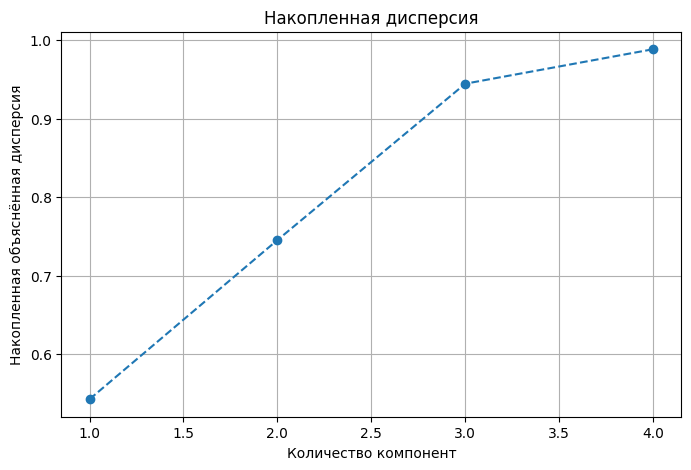

In [66]:
vif_data_after = pd.DataFrame()
vif_data_after["Feature"] = [f"PC{i+1}" for i in range(X_pca.shape[1])]
vif_data_after["VIF"] = [variance_inflation_factor(X_pca, i) for i in range(X_pca.shape[1])]

print(vif_data_after)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Количество компонент')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.title('Накопленная дисперсия')
plt.grid(True)
plt.show()

По методу локтя: 2 компонент, 0.7454


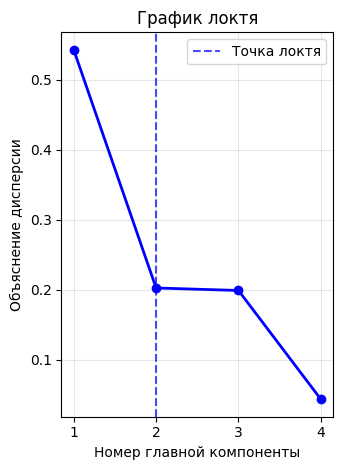

In [65]:
elbow_point = 2
individual_var = pca.explained_variance_ratio_

print(f"По методу локтя: {elbow_point} компонент, {np.cumsum(individual_var)[elbow_point-1]:.4f}")

plt.subplot(1,2,2)
plt.plot(range(1, len(individual_var) + 1), individual_var, "bo-", linewidth=2, markersize=6)
plt.axvline(x=elbow_point, color="b", linestyle="--", alpha=0.7, label="Точка локтя")
plt.xlabel("Номер главной компоненты")
plt.ylabel("Объяснение дисперсии")
plt.title("График локтя")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

После применения PCA все главные компоненты стали ортогональными, что подтверждается VIF = 1 для каждой компоненты - мультиколлинеарность полностью устранена.

In [88]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

lin_reg_pca = LinearRegression()
lin_reg_pca.fit(X_train_pca, y_train_pca)
y_pred_lin_pca = lin_reg_pca.predict(X_test_pca)

print("Линейная регрессия (PCA):")
print("R^2:", r2_score(y_test_pca, y_pred_lin_pca))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pca, y_pred_lin_pca)))
print("MAPE:", mean_absolute_percentage_error(y_test_pca, y_pred_lin_pca))

Линейная регрессия (PCA):
R^2: 0.9868865771812578
RMSE: 2651.685042554291
MAPE: 0.26337712280965203


После применения PCA линейная регрессия показала практически идеальную точность (R^2 = 0.99, RMSE = 2651.68, MAPE = 26%), так как мультиколлинеарность была устранена и модель эффективно использует независимые компоненты.

In [89]:
ridge_reg_pca = Ridge(alpha=1.0)
ridge_reg_pca.fit(X_train_pca, y_train_pca)
y_pred_ridge_pca = ridge_reg_pca.predict(X_test_pca)

print("\nГребневая регрессия (Ridge, PCA):")
print("R^2:", r2_score(y_test_pca, y_pred_ridge_pca))
print("RMSE:", np.sqrt(mean_squared_error(y_test_pca, y_pred_ridge_pca)))
print("MAPE:", mean_absolute_percentage_error(y_test_pca, y_pred_ridge_pca))


Гребневая регрессия (Ridge, PCA):
R^2: 0.9868888902423584
RMSE: 2651.451168450547
MAPE: 0.26349034677610167


После применения PCA гребневая регрессия показала очень высокую точность (R^2 = 0.98, RMSE = 2651.45, MAPE = 26%), так как мультиколлинеарность устранена и модель эффективно использует ортогональные компоненты.